# 1 preparing the data and workflow

The problem it to predict customres who can not be able to pay the car loan using machin learning models and choose one with the best effect

## Set the view and install necessary libraries

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [1]:
import numpy as np
import pandas as pd
import datetime
import re
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost
from matplotlib.pyplot import figure

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, GridSearchCV

from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing import StandardScaler

from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats.distributions import uniform, randint
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn import  metrics


In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

## Download the data set

In [3]:
dataset = pd.read_csv('train.csv')
dataset.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,03-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,26-09-18,6,1998,1,1,0,0,0,0,598,I-Medium Risk,1,1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,01-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,26-10-18,6,1998,1,1,0,0,0,0,305,L-Very High Risk,3,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,26-09-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


## I have to cut the data because i'm not able to train models

In [4]:
val_true = dataset[dataset['loan_default']==1]
val_false = dataset[dataset['loan_default']==0]

val_false.reset_index(drop=True)
val_true.reset_index(drop=True)

val_false=val_false.sample(n=8_000, random_state=1)
# val_false.reset_index(drop=True)

val_true=val_true.sample(n=10_000, random_state=1)    
# val_true.reset_index(drop=True)

dataset = pd.concat([val_true,val_false])
dataset.reset_index(drop=True) 
# dataset = dataset.groupby('loan_default').sample(n=10_500, random_state=1) # po 8k każdy 50/50
dataset['loan_default'].value_counts()

1    10000
0     8000
Name: loan_default, dtype: int64

## Checking how the data looks like


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18000 entries, 176507 to 164950
Data columns (total 41 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   UniqueID                             18000 non-null  int64  
 1   disbursed_amount                     18000 non-null  int64  
 2   asset_cost                           18000 non-null  int64  
 3   ltv                                  18000 non-null  float64
 4   branch_id                            18000 non-null  int64  
 5   supplier_id                          18000 non-null  int64  
 6   manufacturer_id                      18000 non-null  int64  
 7   Current_pincode_ID                   18000 non-null  int64  
 8   Date.of.Birth                        18000 non-null  object 
 9   Employment.Type                      17427 non-null  object 
 10  DisbursalDate                        18000 non-null  object 
 11  State_ID              

In [6]:
dataset.describe()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,NO.OF_INQUIRIES,loan_default
count,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.0,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,1.800000e+04,1.800000e+04,1.800000e+04,18000.000000,18000.000000,18000.000000,1.800000e+04,1.800000e+04,1.800000e+04,1.800000e+04,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000
mean,538389.713278,55147.249611,75954.917556,75.717023,75.065778,19726.305333,68.517833,3471.639833,7.438000,1559.420222,1.0,0.822222,0.075722,0.164833,0.022778,0.001611,271.823667,2.266889,0.972000,0.178944,1.533888e+05,1.977534e+05,1.974238e+05,0.051722,0.023611,0.007111,5.231859e+03,7.943036e+03,7.870932e+03,1.142861e+04,202.809611,0.349056,0.109778,0.226611,0.555556
std,69306.648465,12486.712668,18381.561599,10.990923,70.965828,3477.084507,22.209307,2243.422698,4.489995,978.857623,0.0,0.382336,0.264560,0.371040,0.149198,0.040107,330.095774,5.001427,2.100771,0.596517,8.814510e+05,1.195571e+06,1.196250e+06,0.577118,0.274979,0.101953,1.796529e+05,2.300128e+05,2.298102e+05,1.041031e+05,6623.609193,0.880803,0.402164,0.739038,0.496918
min,417428.000000,13814.000000,38059.000000,18.940000,1.000000,12311.000000,45.000000,1.000000,1.000000,1.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.499920e+05,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,-1.030000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,478486.500000,48145.000000,65781.000000,70.180000,15.000000,16609.000000,45.000000,1519.000000,4.000000,713.750000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
50%,540610.500000,54477.000000,71041.500000,78.100000,64.000000,20478.000000,86.000000,2994.000000,6.000000,1467.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000
75%,599398.000000,61079.750000,79616.250000,84.220000,135.000000,23048.000000,86.000000,5729.000000,11.000000,2382.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,646.000000,2.000000,1.000000,0.000000,2.934425e+04,5.500000e+04,5.408950e+04,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.861000e+03,0.000000,0.000000,0.000000,0.000000,1.000000
max,658655.000000,170146.000000,259000.000000,95.000000,261.000000,24797.000000,153.000000,7343.000000,22.000000,3789.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,879.000000,194.000000,144.000000,19.000000,4.505116e+07,9.262282e+07,9.262873e+07,30.000000,15.000000,4.000000,1.963828e+07,1.980000e+07,1.980000e+07,7.663110e+06,497489.000000,14.000000,8.000000,14.000000,1.000000


In [7]:
dataset.isnull().sum()

UniqueID                                 0
disbursed_amount                         0
asset_cost                               0
ltv                                      0
branch_id                                0
supplier_id                              0
manufacturer_id                          0
Current_pincode_ID                       0
Date.of.Birth                            0
Employment.Type                        573
DisbursalDate                            0
State_ID                                 0
Employee_code_ID                         0
MobileNo_Avl_Flag                        0
Aadhar_flag                              0
PAN_flag                                 0
VoterID_flag                             0
Driving_flag                             0
Passport_flag                            0
PERFORM_CNS.SCORE                        0
PERFORM_CNS.SCORE.DESCRIPTION            0
PRI.NO.OF.ACCTS                          0
PRI.ACTIVE.ACCTS                         0
PRI.OVERDUE

## Checking how looks like churn / non-churn split

In [8]:
dataset['loan_default'].value_counts()

1    10000
0     8000
Name: loan_default, dtype: int64

## Change string value into numeric

In [9]:
dataset[['AVERAGE_y','AVERAGE_m']]= [x.split(' ') for x in dataset['AVERAGE.ACCT.AGE']]
dataset['AVERAGE_y']  = [ re.sub("[^0-9]", "", x) for x in dataset['AVERAGE_y']]
dataset['AVERAGE_y'] = pd.to_numeric(dataset['AVERAGE_y'])
dataset['AVERAGE_m']  = [ re.sub("[^0-9]", "", x) for x in dataset['AVERAGE_m']]
dataset['AVERAGE_m']  = pd.to_numeric(dataset['AVERAGE_m'])
dataset['AVERAGE.ACCT.AGE'] =  (dataset['AVERAGE_y']*12)+ dataset['AVERAGE_m']


In [10]:
dataset[['CREDIT_y','CREDIT_m']]= [x.split(' ') for x in dataset['CREDIT.HISTORY.LENGTH']]
dataset['CREDIT_y']  = [ re.sub("[^0-9]", "", x) for x in dataset['CREDIT_y']]
dataset['CREDIT_y'] = pd.to_numeric(dataset['CREDIT_y'])
dataset['CREDIT_m']  = [ re.sub("[^0-9]", "", x) for x in dataset['CREDIT_m']]
dataset['CREDIT_m']  = pd.to_numeric(dataset['CREDIT_m'])
dataset['CREDIT.HISTORY.LENGTH'] =  (dataset['CREDIT_y']*12)+ dataset['CREDIT_m']


## Change date to date value

In [11]:
def change_to_date(dataset,column):
    dataset[column]=[datetime.datetime.strptime(x,"%d-%m-%y") for x in dataset[column]]
    
    
change_to_date(dataset,'Date.of.Birth')


In [12]:
    
change_to_date(dataset,'DisbursalDate')

## Drop supperted columns

In [13]:
dataset.drop(columns=['AVERAGE_y','AVERAGE_m','CREDIT_y','CREDIT_m'],inplace=True)


## Checking unique values in each column

In [14]:
calumn_list = list()

number_of_unique_values = list()

for column in dataset.columns :
    calumn_list.append((column,dataset[column].nunique()))
# calumn_list

## Checking unique values for each column

In [15]:
dataset.nunique()

UniqueID                               18000
disbursed_amount                        5176
asset_cost                             11557
ltv                                     4057
branch_id                                 82
supplier_id                             2264
manufacturer_id                            9
Current_pincode_ID                      3920
Date.of.Birth                           7316
Employment.Type                            2
DisbursalDate                             84
State_ID                                  22
Employee_code_ID                        2866
MobileNo_Avl_Flag                          1
Aadhar_flag                                2
PAN_flag                                   2
VoterID_flag                               2
Driving_flag                               2
Passport_flag                              2
PERFORM_CNS.SCORE                        518
PERFORM_CNS.SCORE.DESCRIPTION             20
PRI.NO.OF.ACCTS                           66
PRI.ACTIVE

## Delete unnecessary columns

In [16]:
dataset.drop(columns=['UniqueID','MobileNo_Avl_Flag'],inplace=True)

## Checking the data again

In [17]:
different_value=dataset.columns.to_series().groupby(dataset.dtypes).groups
different_value

{int64: ['disbursed_amount', 'asset_cost', 'branch_id', 'supplier_id', 'manufacturer_id', 'Current_pincode_ID', 'State_ID', 'Employee_code_ID', 'Aadhar_flag', 'PAN_flag', 'VoterID_flag', 'Driving_flag', 'Passport_flag', 'PERFORM_CNS.SCORE', 'PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS', 'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT', 'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS', 'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT', 'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT', 'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES', 'loan_default'], float64: ['ltv'], datetime64[ns]: ['Date.of.Birth', 'DisbursalDate'], object: ['Employment.Type', 'PERFORM_CNS.SCORE.DESCRIPTION']}

In [18]:
dataset.isna().sum()

disbursed_amount                         0
asset_cost                               0
ltv                                      0
branch_id                                0
supplier_id                              0
manufacturer_id                          0
Current_pincode_ID                       0
Date.of.Birth                            0
Employment.Type                        573
DisbursalDate                            0
State_ID                                 0
Employee_code_ID                         0
Aadhar_flag                              0
PAN_flag                                 0
VoterID_flag                             0
Driving_flag                             0
Passport_flag                            0
PERFORM_CNS.SCORE                        0
PERFORM_CNS.SCORE.DESCRIPTION            0
PRI.NO.OF.ACCTS                          0
PRI.ACTIVE.ACCTS                         0
PRI.OVERDUE.ACCTS                        0
PRI.CURRENT.BALANCE                      0
PRI.SANCTIO

In [19]:
dataset['Employment.Type'].value_counts()

Self employed    10114
Salaried          7313
Name: Employment.Type, dtype: int64

## Most of the type of employment is self-employment, so I will overwrite the 3% of the missing values with the most popular one

In [20]:
dataset['Employment.Type'].fillna(value=dataset['Employment.Type'].value_counts().index[0],inplace=True)
dataset['Employment.Type'].value_counts()

Self employed    10687
Salaried          7313
Name: Employment.Type, dtype: int64

In [21]:
dataset.isna().sum().sum()

0

#  I have to change int value to float

In [22]:
column_to_convert = list()

for column,types in zip(dataset.columns,dataset.dtypes):
    if types == 'int64': 
        column_to_convert.append(column)
column_to_convert


dataset[column_to_convert] = dataset[column_to_convert].astype(float)

## to check data I need to change from non-numeric  to numeric value

In [23]:
pca_data = copy.deepcopy(dataset)


### choosing category values 

In [24]:
column_to_cat = list()

for column,types in zip(pca_data.columns,pca_data.dtypes):
    if  types =='float64' or types == 'int64':
        continue
    else:
        column_to_cat.append(column)
column_to_cat



['Date.of.Birth',
 'Employment.Type',
 'DisbursalDate',
 'PERFORM_CNS.SCORE.DESCRIPTION']

### choosing numeric values

In [25]:
column_to_convert = list()

for column,types in zip(pca_data.columns,pca_data.dtypes):
    if types == 'int64' or types == 'int32' : 
        column_to_convert.append(column)
column_to_convert


pca_data[column_to_convert] = pca_data[column_to_convert].astype(float)

In [26]:
label_encoder = LabelEncoder()
for column in pca_data[column_to_cat]:
    pca_data[column]= label_encoder.fit_transform(pca_data[column])


In [27]:
column_to_num = list()

for column,types in zip(pca_data.columns,pca_data.dtypes):
    if  types =='float64' or types == 'int64' or types == 'int32':
        column_to_num.append(column)
    else:
        continue    

In [28]:
pca_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18000 entries, 176507 to 164950
Data columns (total 39 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   disbursed_amount                     18000 non-null  float64
 1   asset_cost                           18000 non-null  float64
 2   ltv                                  18000 non-null  float64
 3   branch_id                            18000 non-null  float64
 4   supplier_id                          18000 non-null  float64
 5   manufacturer_id                      18000 non-null  float64
 6   Current_pincode_ID                   18000 non-null  float64
 7   Date.of.Birth                        18000 non-null  int64  
 8   Employment.Type                      18000 non-null  int64  
 9   DisbursalDate                        18000 non-null  int64  
 10  State_ID                             18000 non-null  float64
 11  Employee_code_ID      

## Checking importance of columns

## Check correlation between columns and delete non-importance

In [29]:
dataset2 = pca_data[column_to_num]

correlations = dataset2.corrwith(dataset2['loan_default'])
correlations = correlations[correlations!=1]
# correlations=correlations.drop(columns='loan_default',inplace=True)
positive_correlations = correlations[correlations >0].sort_values(ascending = False)
negative_correlations = correlations[correlations<0].sort_values(ascending = False)

print('Most Positive Correlations: \n', positive_correlations)
print('\nMost Negative Correlations: \n', negative_correlations)


Most Positive Correlations: 
 ltv                                    0.124652
disbursed_amount                       0.100056
PERFORM_CNS.SCORE.DESCRIPTION          0.087090
State_ID                               0.061805
VoterID_flag                           0.056249
branch_id                              0.051507
NO.OF_INQUIRIES                        0.050362
DisbursalDate                          0.043355
DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS    0.035369
Employment.Type                        0.034323
Current_pincode_ID                     0.032332
supplier_id                            0.027752
Employee_code_ID                       0.027202
Date.of.Birth                          0.021803
PRI.OVERDUE.ACCTS                      0.019785
asset_cost                             0.019509
Driving_flag                           0.009159
PAN_flag                               0.000329
dtype: float64

Most Negative Correlations: 
 SEC.OVERDUE.ACCTS              -0.001218
SEC.CURRENT.BALANCE

Text(0.5, 1.0, 'Correlation with Churn Rate \n')

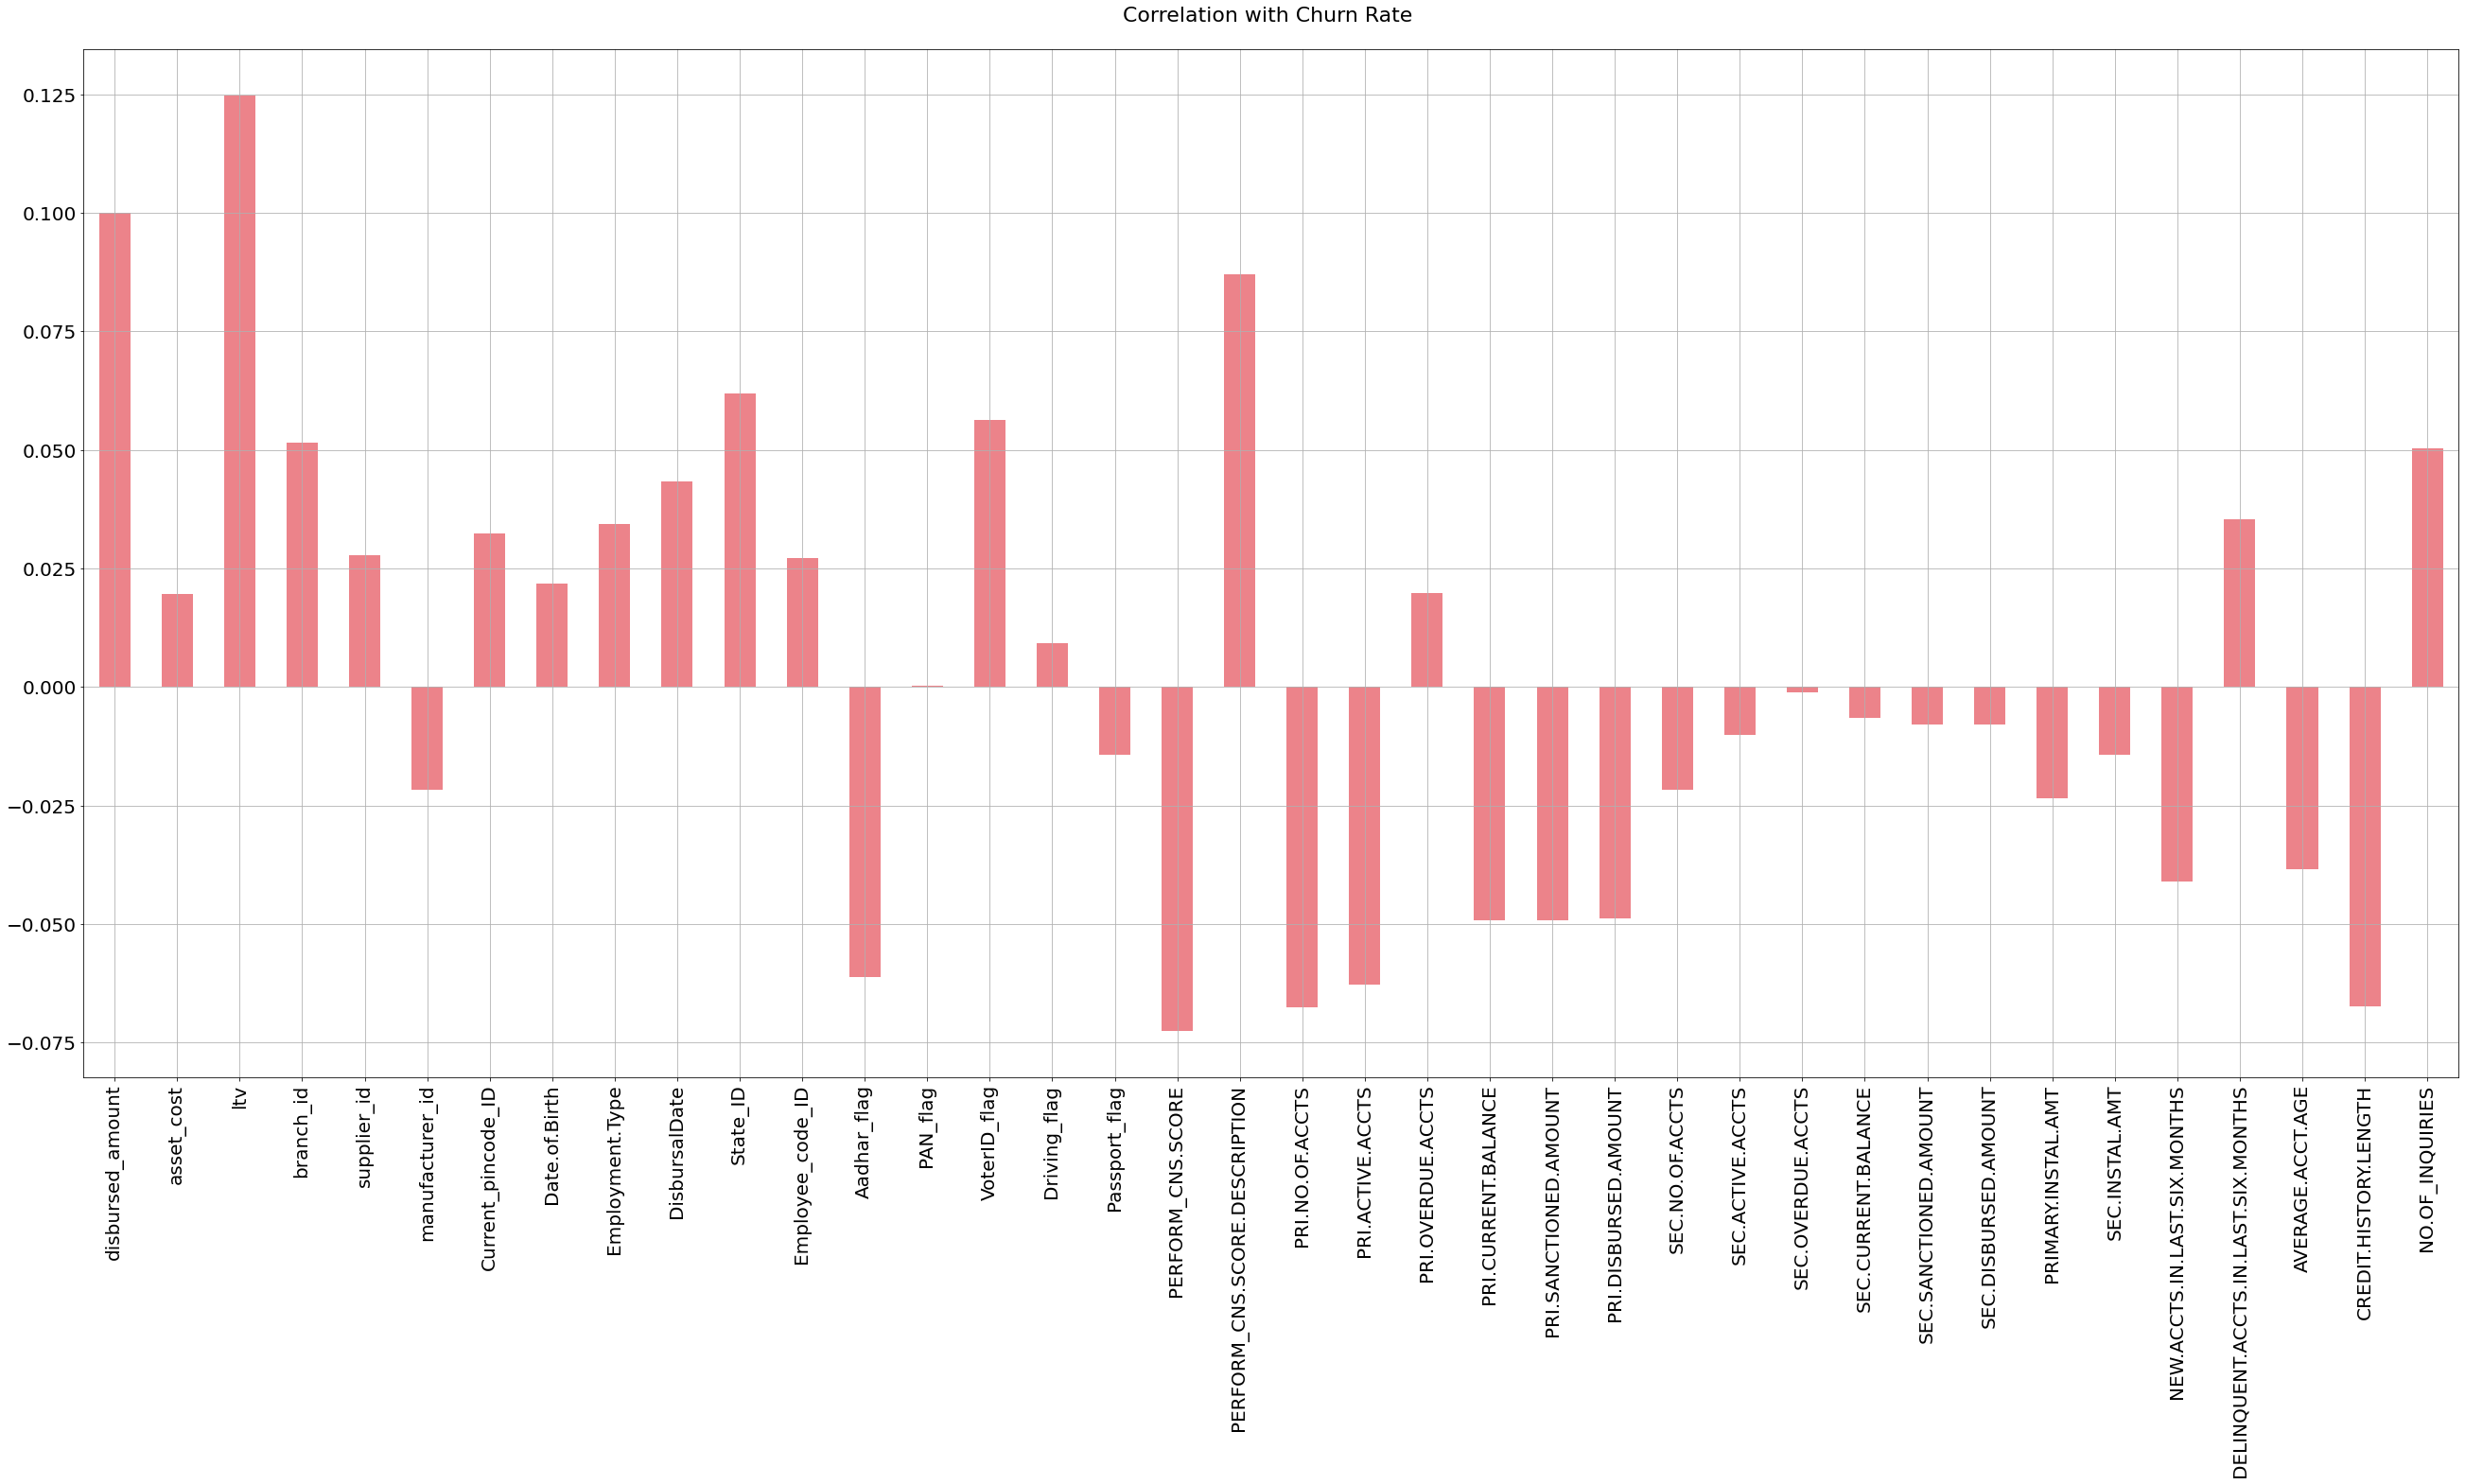

In [30]:
orrelations = dataset2.corrwith(pca_data['loan_default'])
correlations = correlations[correlations<0.99]

correlations.plot.bar(
        figsize = (45, 20), fontsize = 20, color = '#ec838a',
        rot = 90, grid = True)

plt.title('Correlation with Churn Rate \n',horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")


<ipython-input-31-b6b37baf9513>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


<AxesSubplot:>

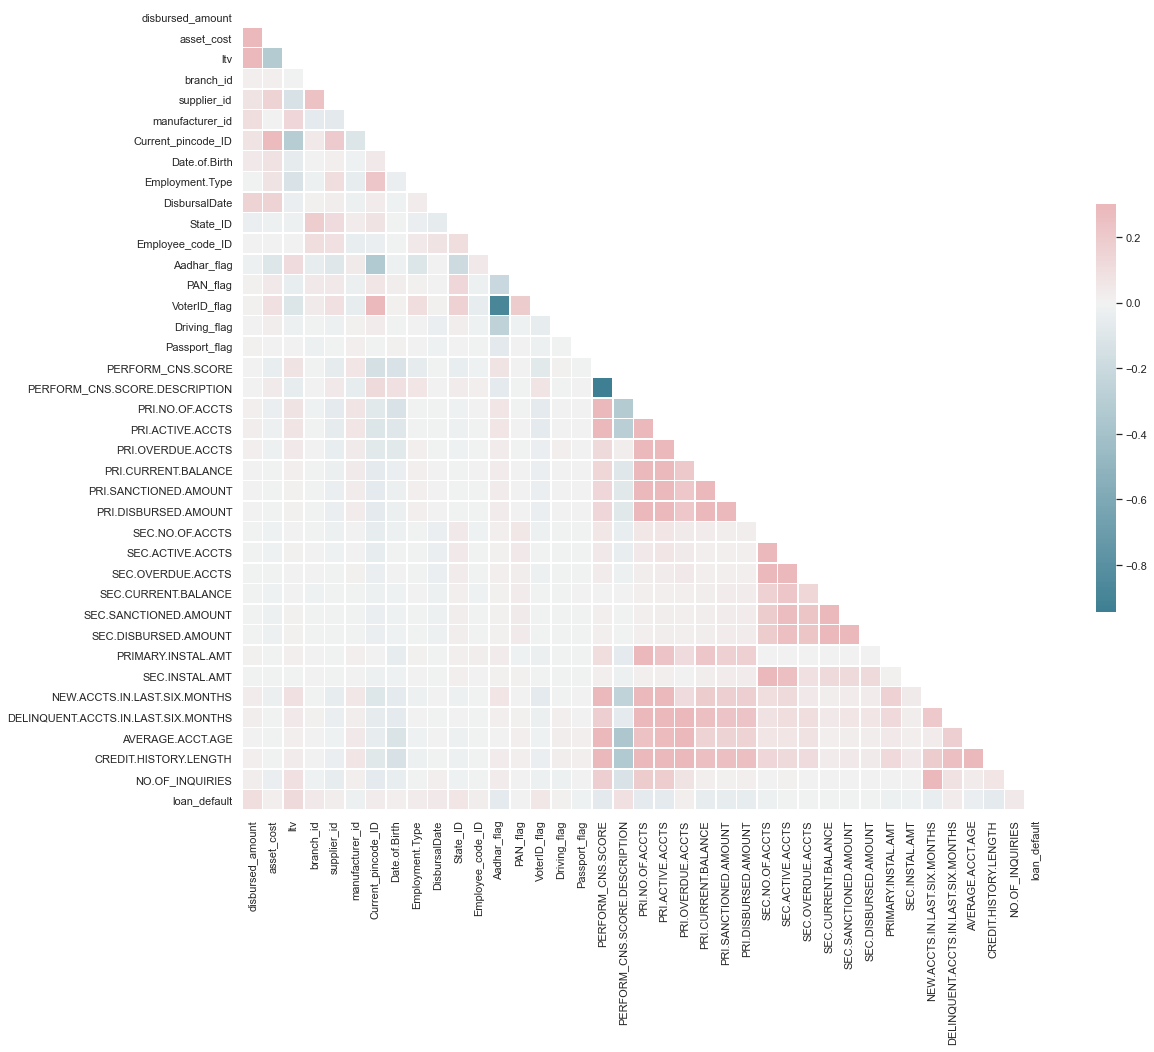

In [31]:
#Set and compute the Correlation Matrix:
sns.set(style="white")
corr = dataset2.corr()
#Generate a mask for the upper triangle:
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
#Set up the matplotlib figure and a diverging colormap:
f, ax = plt.subplots(figsize=(18, 15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
#Draw the heatmap with the mask and correct aspect ratio:
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [32]:
model = PCA()
model.fit(pca_data)
pca_features = model.fit_transform(pca_data)

In [33]:
model.explained_variance_

array([3.56446079e+12, 1.31181501e+11, 7.27363376e+10, 1.01453029e+10,
       6.70701613e+09, 9.56724304e+08, 4.42996121e+08, 5.17064206e+07,
       4.31471794e+07, 1.18113044e+07, 4.28289879e+06, 4.05885292e+06,
       3.93707683e+06, 9.43804413e+05, 1.02374769e+05, 4.70711019e+03,
       6.40766943e+02, 6.15711751e+02, 4.69593288e+02, 5.25547283e+01,
       1.88759416e+01, 1.23483660e+01, 8.35042288e+00, 2.26637341e+00,
       1.15866642e+00, 5.08345687e-01, 3.28563475e-01, 2.70433250e-01,
       2.47674732e-01, 2.23766304e-01, 2.17504879e-01, 2.13626766e-01,
       1.00847402e-01, 6.48535109e-02, 3.15430049e-02, 1.70613954e-02,
       6.89610065e-03, 6.50372529e-03, 1.46675682e-03])

In [34]:
model.explained_variance_ratio_

array([9.41297990e-01, 3.46422336e-02, 1.92081138e-02, 2.67915790e-03,
       1.77117976e-03, 2.52650462e-04, 1.16985817e-04, 1.36545617e-05,
       1.13942488e-05, 3.11911331e-06, 1.13102213e-06, 1.07185640e-06,
       1.03969793e-06, 2.49238595e-07, 2.70349908e-08, 1.24304730e-09,
       1.69212869e-10, 1.62596328e-10, 1.24009561e-10, 1.38785817e-11,
       4.98473317e-12, 3.26093982e-12, 2.20516839e-12, 5.98500828e-13,
       3.05979062e-13, 1.34243242e-13, 8.67665988e-14, 7.14156474e-14,
       6.54056086e-14, 5.90919033e-14, 5.74383947e-14, 5.64142679e-14,
       2.66316457e-14, 1.71264276e-14, 8.32983413e-15, 4.50555024e-15,
       1.82111295e-15, 1.71749499e-15, 3.87339159e-16])

## shows relation in barplot sum and cumulative sum

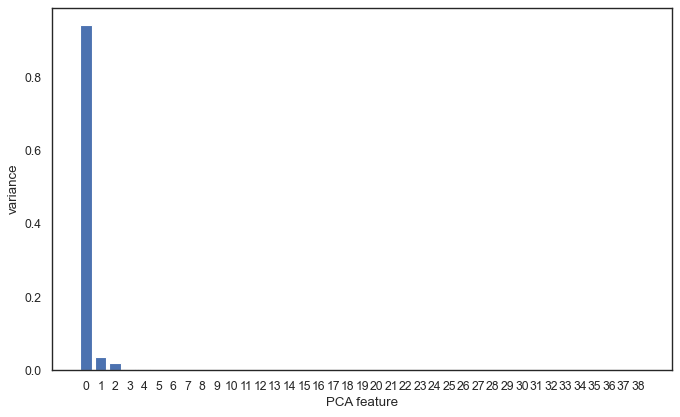

In [35]:
figure(figsize=(10, 6), dpi=80)

features = range(model.n_components_)

plt.bar(features, model.explained_variance_ratio_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

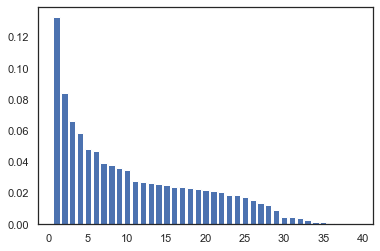

In [36]:
pca = PCA()
pca.fit(scale(pca_data))
plt.bar(range(1,1+pca.n_components_),pca.explained_variance_ratio_)
plt.show()

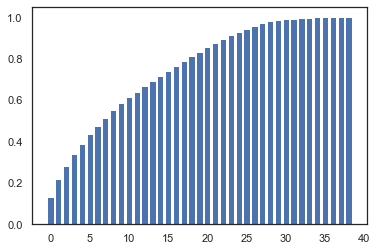

In [37]:
plt.bar(range(pca.n_components_),np.cumsum(pca.explained_variance_ratio_))
plt.show()

### Chceking importance using SVM and PCA

In [365]:
# pca_data = pca_data.sample(n=20_000)

In [38]:
pca_data['loan_default'].value_counts()

1.0    10000
0.0     8000
Name: loan_default, dtype: int64

In [39]:
X_p = pca_data.drop(['loan_default'], axis=1)
y_p = pca_data['loan_default'].values




label_encoder = LabelEncoder()
y_p = label_encoder.fit_transform(y_p)

print(f"X.shape: {X_p.shape} y.shape: { y_p.shape}")

X.shape: (18000, 38) y.shape: (18000,)


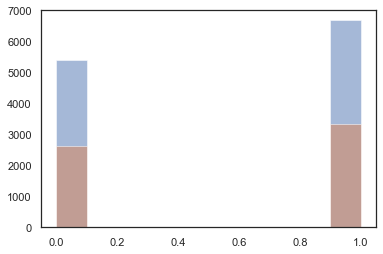

In [40]:
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_p, y_p, test_size=0.33, random_state=42)

plt.hist(y_train_p, alpha=0.5)
plt.hist(y_test_p, alpha=0.5)
plt.show()

In [41]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_p)
pca = PCA()
X_pca = pca.fit_transform(X_train_scaled)
total_explained_variance = pca.explained_variance_ratio_.cumsum()
n_over_95 = len(total_explained_variance[total_explained_variance >= .95])
n_to_reach_95 = X_p.shape[1] - n_over_95 + 1
print("Number features: {}\tTotal Variance Explained: {}".format(n_to_reach_95, total_explained_variance[n_to_reach_95 - 1]))

Number features: 26	Total Variance Explained: 0.9584532610580944


In [42]:
pipe = Pipeline([('scaler', StandardScaler()),
 ('pca', PCA(n_components=n_to_reach_95)),
 ('clf', RandomForestClassifier())])
pipe.fit(X_train_p,y_train_p)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=26)),
                ('clf', RandomForestClassifier())])

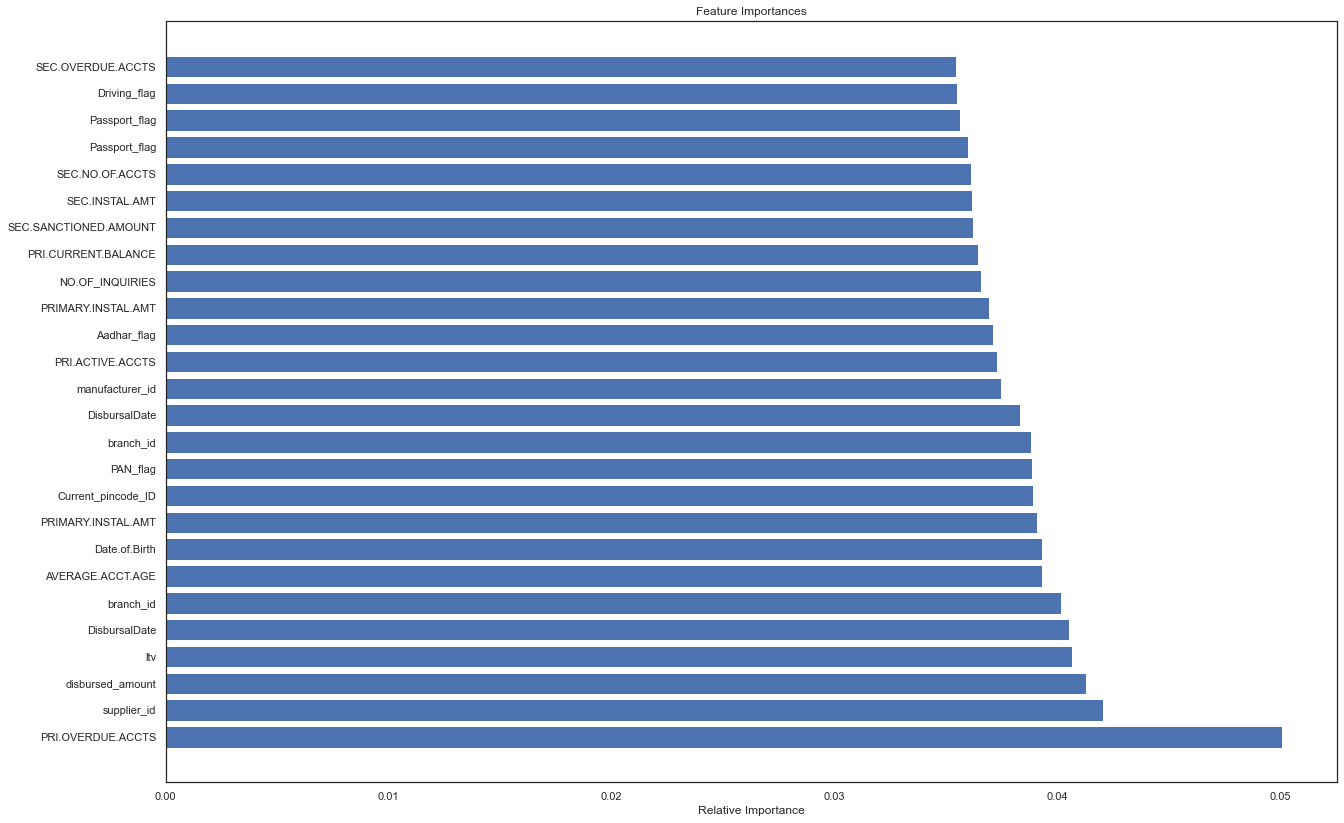

In [43]:
model = pipe.steps[1][1]
n_pcs= model.components_.shape[0]
initial_feature_names = X_train_p.columns
most_important = [np.abs(model.components_[i]).argmax() for i in     range(n_pcs)]
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
zipped_feats = zip(most_important_names, pipe.steps[2][1].feature_importances_)
zipped_feats = sorted(zipped_feats, key=lambda x: x[1], reverse=True)
features, importances = zip(*zipped_feats)
top_features = features[:28]
top_importances = importances[:28]
plt.figure(figsize=(21,14)) 
plt.title('Feature Importances')
plt.barh(range(len(top_importances)), top_importances, color='b', align='center')
plt.yticks(range(len(top_importances)), top_features)
plt.xlabel('Relative Importance')
plt.show()

In [83]:
# top_features = features[:28]
top_features=list(set(top_features))
len(top_features)

22

In [47]:
logreg001 = LogisticRegression(C=0.001, penalty='l1', solver='liblinear').fit(X_train_p, y_train_p)

print("Training set score: {:.3f}".format(logreg001.score(X_train_p, y_train_p)))
print("Test set score: {:.3f}".format(logreg001.score(X_test_p, y_test_p)))

print(f'f1 score {metrics.f1_score(y_test_p , logreg001.predict(X_test_p))}')

print(f'accuracy_score {metrics.accuracy_score(y_test_p , logreg001.predict(X_test_p))}')
print("roc_auc_score: {}".format( metrics.roc_auc_score(y_test_p , logreg001.predict_proba(X_test_p)[:,1]) ))

Training set score: 0.592
Test set score: 0.599
f1 score 0.7018905721797921
accuracy_score 0.5991582491582491
roc_auc_score: 0.6116764915150013


In [46]:
logreg1 = LogisticRegression(C=1, penalty='l1', solver='liblinear').fit(X_train_p, y_train_p)

print("Training set score: {:.3f}".format(logreg1.score(X_train_p, y_train_p)))
print("Test set score: {:.3f}".format(logreg1.score(X_test_p, y_test_p)))

print(f'f1 score {metrics.f1_score(y_test_p , logreg1.predict(X_test_p))}')

print(f'accuracy_score {metrics.accuracy_score(y_test_p , logreg1.predict(X_test_p))}')

print("roc_auc_score: {}".format( metrics.roc_auc_score(y_test_p , logreg1.predict_proba(X_test_p)[:,1]) ))

Training set score: 0.613
Test set score: 0.620
f1 score 0.7033486539724227
accuracy_score 0.6196969696969697
roc_auc_score: 0.6369708575236782


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [49]:
logreg100 = LogisticRegression(C=100, penalty='l1', solver='liblinear').fit(X_train_p, y_train_p)

print("Training set score: {:.3f}".format(logreg100.score(X_train_p, y_train_p)))
print("Test set score: {:.3f}".format(logreg100.score(X_test_p, y_test_p)))


print(f'accuracy_score {metrics.accuracy_score(y_test_p , logreg100.predict(X_test_p))}')

print("roc_auc_score: {}".format( metrics.roc_auc_score(y_test_p , logreg100.predict_proba(X_test_p)[:,1]) ))

Training set score: 0.614
Test set score: 0.621
accuracy_score 0.6210437710437711
roc_auc_score: 0.6363312113745941


Training accuracy of l1 logreg with C=0.001: 0.59
Test accuracy of l1 logreg with C=0.001: 0.60


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Training accuracy of l1 logreg with C=1.000: 0.61
Test accuracy of l1 logreg with C=1.000: 0.62


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Training accuracy of l1 logreg with C=100.000: 0.61
Test accuracy of l1 logreg with C=100.000: 0.62


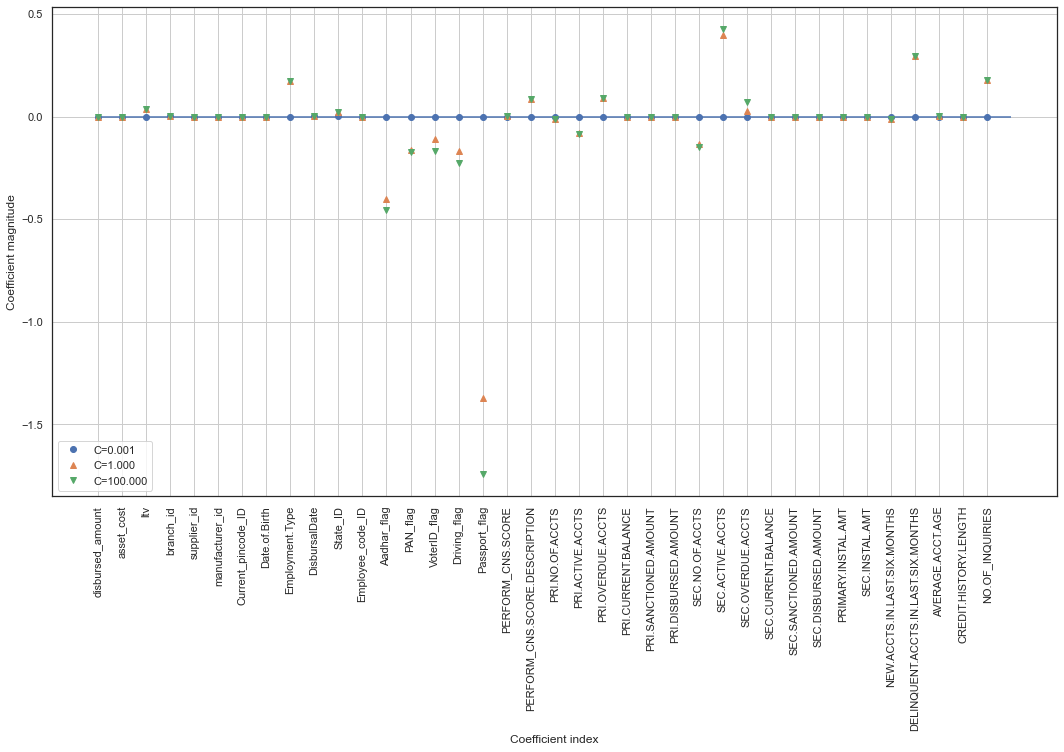

In [50]:
plt.figure(figsize=(18,9)) 
for C, marker in zip([0.001, 1, 100], ['o', '^', 'v']):
    lr_l1 = LogisticRegression(C=C, penalty="l1", solver='liblinear').fit(X_train_p, y_train_p)
    print("Training accuracy of l1 logreg with C={:.3f}: {:.2f}".format(C, lr_l1.score(X_train_p, y_train_p)))
    print("Test accuracy of l1 logreg with C={:.3f}: {:.2f}".format(C, lr_l1.score(X_test_p, y_test_p)))
    plt.plot(lr_l1.coef_.T, marker, label="C={:.3f}".format(C))

   
plt.xticks(range(X_p.columns.shape[0]), X_p.columns, rotation=90)
plt.hlines(0, 0, X_p.columns.shape[0])
plt.xlabel("Coefficient index")
plt.ylabel("Coefficient magnitude")
# plt.ylim(-5, 5)
plt.grid(b=True)
plt.legend(loc=3)
plt.show()


### I will use  22 columns which	Total Variance Explained: 0.95

In [51]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18000 entries, 176507 to 164950
Data columns (total 39 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   disbursed_amount                     18000 non-null  float64       
 1   asset_cost                           18000 non-null  float64       
 2   ltv                                  18000 non-null  float64       
 3   branch_id                            18000 non-null  float64       
 4   supplier_id                          18000 non-null  float64       
 5   manufacturer_id                      18000 non-null  float64       
 6   Current_pincode_ID                   18000 non-null  float64       
 7   Date.of.Birth                        18000 non-null  datetime64[ns]
 8   Employment.Type                      18000 non-null  object        
 9   DisbursalDate                        18000 non-null  datetime64[ns]
 10  Stat

# Prepare data to next step (train / test split) 

In [52]:
X = dataset.drop(['loan_default'], axis=1)
y = dataset['loan_default'].values




label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

print(f"X.shape: {X.shape} y.shape: { y.shape}")

X.shape: (18000, 38) y.shape: (18000,)


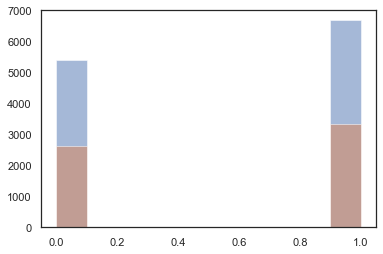

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

plt.hist(y_train, alpha=0.5)
plt.hist(y_test, alpha=0.5)
plt.show()

In [54]:
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (12060, 38)
Number transactions y_train dataset:  (12060,)
Number transactions X_test dataset:  (5940, 38)
Number transactions y_test dataset:  (5940,)


In [55]:
column_to_cat = list()

for column,types in zip(X_train.columns,X_train.dtypes):
    if  types =='float64' or types == 'int64':
        continue
    else:
        column_to_cat.append(column)
column_to_cat

X_train[column_to_cat]

,Date.of.Birth,Employment.Type,DisbursalDate,PERFORM_CNS.SCORE.DESCRIPTION
158928,1985-01-01,Self employed,2018-08-18,E-Low Risk
187031,1991-10-05,Salaried,2018-08-23,No Bureau History Available
168101,1991-06-26,Self employed,2018-09-23,H-Medium Risk
89346,1996-12-05,Salaried,2018-10-20,No Bureau History Available
105918,1986-07-10,Salaried,2018-09-20,No Bureau History Available
...,...,...,...,...
145130,1981-12-24,Self employed,2018-10-31,C-Very Low Risk
74009,1997-11-30,Self employed,2018-08-04,No Bureau History Available
205912,1997-05-18,Salaried,2018-10-03,No Bureau History Available
65710,1976-06-05,Self employed,2018-08-10,K-High Risk


In [56]:
column_to_num = list()

for column,types in zip(X_train.columns,X_train.dtypes):
    if  types =='float64' or types == 'int64':
        column_to_num.append(column)
    else:
        continue        

## Create OneHotEncoder for numeric and category values

### start to biuild Pipe line of pracess

In [57]:
# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [58]:
# Inspired from stackoverflow.com/questions/25239958
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

## OneHotEncoder for category values

In [59]:
# from future_encoders import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(column_to_cat)),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False, handle_unknown = 'ignore')),
    ])


cat_pipeline.fit_transform(X_train)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [60]:
num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(column_to_num)),
        ("imputer", SimpleImputer(strategy="median")),
    ])

num_pipeline.fit_transform(X_train)

array([[5.05780e+04, 7.13500e+04, 7.35800e+01, ..., 6.00000e+00,
        1.70000e+01, 0.00000e+00],
       [7.03370e+04, 1.05464e+05, 7.01700e+01, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [5.23590e+04, 7.17010e+04, 7.81000e+01, ..., 8.00000e+00,
        1.70000e+01, 0.00000e+00],
       ...,
       [6.42820e+04, 7.68600e+04, 8.50900e+01, ..., 0.00000e+00,
        0.00000e+00, 1.00000e+00],
       [5.04030e+04, 5.88510e+04, 8.76800e+01, ..., 7.00000e+00,
        1.20000e+01, 0.00000e+00],
       [6.20470e+04, 7.14360e+04, 8.90300e+01, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00]])

## Connect both Pipelines

In [61]:
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

# Creating models

In [62]:
seed=123
kfold = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)

## LinearSVC

In [ ]:

pipe = Pipeline([('preprocessing', preprocess_pipeline),
                 ('PCA',PCA(n_components=22)),
                 ('classifier', LinearSVC(C=1))])

param_grid = {
            'classifier__C': [ 0.00001,0.0001,0.001,0.01,0.1,1,100,10000,100000] # in test split 0.2 the best is 0,1 , IN SPLIT 0.33 10 or 0.1
            
}

grid_1 = GridSearchCV(pipe, param_grid, cv=kfold, return_train_score=True)

grid_1.fit(X_train, y_train)
grid_1.best_params_


## SVC RBF

In [105]:
pipe_2 = Pipeline([('preprocessing', preprocess_pipeline),
                   ('PCA',PCA(n_components=22)),
                   ('classifier', SVC(C=1,kernel='rbf', probability=True))])

param_grid_2 = {
            'classifier__C': [ 1,10,100,110],#{'classifier__C': 0.01, 'classifier__gamma': 0.01}
            'classifier__gamma': [0.001,0.01,0.1,1,10]
}

grid_2 = GridSearchCV(pipe_2, param_grid_2, cv=kfold, return_train_score=True)

grid_2.fit(X_train, y_train)
grid_2.best_params_

{'classifier__C': 1, 'classifier__gamma': 10}

In [106]:
results = pd.DataFrame(grid_2.cv_results_)

In [107]:
len(results.mean_test_score)

20

In [108]:
def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f"):
    if ax is None:
        ax = plt.gca()
    # plot the mean cross-validation scores
    img = ax.pcolor(values, cmap=cmap, vmin=vmin, vmax=vmax)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)

    for p, color, value in zip(img.get_paths(), img.get_facecolors(),
                               img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % value, color=c, ha="center", va="center")
    return img

In [112]:
scores = np.array(results.mean_test_score).reshape(4, 5,1)
scores = scores[:,:,0]
scores

array([[0.55273632, 0.55290216, 0.55315091, 0.55331675, 0.55339967],
       [0.55273632, 0.55281924, 0.55315091, 0.55331675, 0.55339967],
       [0.55273632, 0.55281924, 0.55315091, 0.55331675, 0.55339967],
       [0.55273632, 0.55281924, 0.55315091, 0.55331675, 0.55339967]])

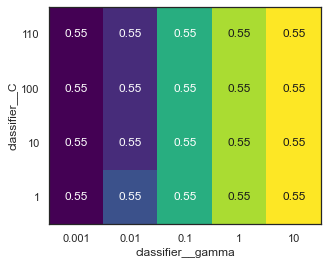

In [113]:
heatmap(scores, xlabel='classifier__gamma', xticklabels=param_grid_2['classifier__gamma'], ylabel='classifier__C', yticklabels=param_grid_2['classifier__C'], cmap="viridis")
plt.show()

In [115]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(grid_2, X_train, y_train, cv=3)
y_train_pred

array([1, 1, 1, ..., 1, 1, 1])

In [116]:

from sklearn.metrics import confusion_matrix

confusion_matrix(y_train, y_train_pred)

array([[   0, 5382],
       [   4, 6674]])

## LogisticRegression

In [87]:
from sklearn.linear_model import LogisticRegression

pipe_3 = Pipeline([('preprocessing', preprocess_pipeline),
                   ('PCA', PCA(n_components=22)),
                  
                   ('classifier', LogisticRegression(C=1,penalty='l2', max_iter=400))
                  ])

param_grid_3 = {
            'classifier__C': [0.0000000001,0.000000001,0.00000001,0.0000001,0.000001] # [0.001 ,0.01, 0.1, 1] best 0.001
            
}

grid_3 = GridSearchCV(pipe_3, param_grid_3, cv=kfold, return_train_score=True)

grid_3.fit(X_train, y_train)
grid_3.best_params_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

{'classifier__C': 1e-09}

### Checking  Confusion Matrix for Logistic Regression

In [88]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(grid_3, X_train, y_train, cv=3)
y_train_pred.mean(axis=0)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

0.5680762852404644

In [89]:


from sklearn.metrics import confusion_matrix

confusion_matrix(y_train, y_train_pred)

array([[2748, 2634],
       [2461, 4217]])

# KNeighborsClassifier

### Checking corelation between accuracy and K Neighbors

In [91]:
X_train_neig = copy.deepcopy(X_train)
X_test_neig = copy.deepcopy(X_test)
name_columns = []
for name in X_train.columns:
    name_columns.append(name)
name_columns

label_encoder = LabelEncoder()
for column in X_train_neig[name_columns]:
    X_train_neig[column]= label_encoder.fit_transform(X_train_neig[column])

for column in X_test_neig[name_columns]:
    X_test_neig[column]= label_encoder.fit_transform(X_test_neig[column])   

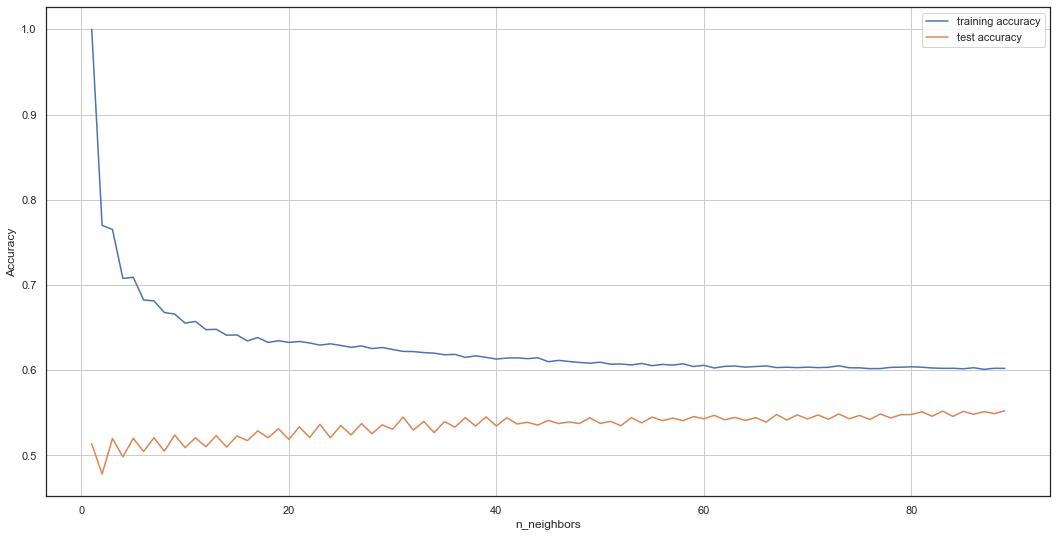

In [129]:
training_accuracy = []
test_accuracy = []

neighbors_settings = range(1, 90)

for n_neighbors in neighbors_settings:
    
    # build the model
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X_train_neig, y_train)
    
    # record training set accuracy
    training_accuracy.append(clf.score(X_train_neig, y_train))
    
    # record generalization accuracy
    test_accuracy.append(clf.score(X_test_neig, y_test))

plt.figure(figsize=(18,9)) 
plt.grid(b=True,)
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()
plt.show()

In [135]:
# from sklearn.neighbors import KNeighborsClassifier

pipe_4 = Pipeline([('preprocessing', preprocess_pipeline),
                   ('PCA',PCA(n_components=26)),
                   ('classifier', KNeighborsClassifier(n_neighbors=2, metric='euclidean'))
                  ])



param_grid_4 = {
            'classifier__n_neighbors':list(range(60,90)), #[ 30,40,50,60],
            'classifier__metric': ['euclidean']
}


grid_4 = GridSearchCV(pipe_4, param_grid_4, cv=kfold, return_train_score=True)

grid_4.fit(X_train, y_train)
grid_4.best_params_

{'classifier__metric': 'euclidean', 'classifier__n_neighbors': 67}

## DecisionTreeClassifier

In [131]:
from sklearn.tree import DecisionTreeClassifier

pipe_5 = Pipeline([('preprocessing', preprocess_pipeline), 
                   ('PCA',PCA(n_components=26)),
                   ('classifier', DecisionTreeClassifier())])

param_grid_5 = {
            'classifier__max_depth': [1,2,3,5],
            'classifier__max_leaf_nodes': [4,5,6,7,8,9,10],
            'classifier__min_samples_split': [1,2,3,5]
            
}


grid_5 = GridSearchCV(pipe_5, param_grid_5, cv=kfold, return_train_score=True)

grid_5.fit(X_train, y_train)
grid_5.best_params_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 898, in fit
    super().fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 237, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  warnings.warn("Estimator fit failed. The score o

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 898, in fit
    super().fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 237, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  warnings.warn("Estimator fit failed. The score o

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 898, in fit
    super().fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 237, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  warnings.warn("Estimator fit failed. The score o

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 898, in fit
    super().fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 237, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  warnings.warn("Estimator fit failed. The score o

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 898, in fit
    super().fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 237, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  warnings.warn("Estimator fit failed. The score o

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 898, in fit
    super().fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 237, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  warnings.warn("Estimator fit failed. The score o

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 898, in fit
    super().fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 237, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  warnings.warn("Estimator fit failed. The score o

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 898, in fit
    super().fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 237, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  warnings.warn("Estimator fit failed. The score o

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 898, in fit
    super().fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 237, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  warnings.warn("Estimator fit failed. The score o

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 898, in fit
    super().fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 237, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  warnings.warn("Estimator fit failed. The score o

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 898, in fit
    super().fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 237, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  warnings.warn("Estimator fit failed. The score o

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 898, in fit
    super().fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 237, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  warnings.warn("Estimator fit failed. The score o

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 898, in fit
    super().fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 237, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  warnings.warn("Estimator fit failed. The score o

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 898, in fit
    super().fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 237, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  warnings.warn("Estimator fit failed. The score o

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 898, in fit
    super().fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 237, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  warnings.warn("Estimator fit failed. The score o

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 898, in fit
    super().fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 237, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  warnings.warn("Estimator fit failed. The score o

{'classifier__max_depth': 3,
 'classifier__max_leaf_nodes': 8,
 'classifier__min_samples_split': 2}

## BaggingClassifier

In [132]:
# from sklearn.ensemble import BaggingClassifier
# from sklearn.tree import DecisionTreeClassifier

pipe_6 = Pipeline([('preprocessing', preprocess_pipeline),
                   ('PCA',PCA(n_components=22)),
                   ('classifier', BaggingClassifier(
                                    DecisionTreeClassifier(random_state=42), n_estimators=500,
                                    max_samples=100, bootstrap=True, random_state=42))
                  ])

param_grid_6 = {'classifier__max_samples': [11,15,20,25],
                'classifier__n_estimators': [10,20,30,49]
              
             }

grid_6 = GridSearchCV(pipe_6, param_grid_6, cv=kfold, return_train_score=True)

grid_6.fit(X_train, y_train)
grid_6.best_params_

{'classifier__max_samples': 20, 'classifier__n_estimators': 49}

## RandomForestClassifier

In [121]:
from sklearn.ensemble import RandomForestClassifier

pipe_7 = Pipeline([('preprocessing', preprocess_pipeline), 
                   ('PCA',PCA(n_components=26)),
                   ('classifier', RandomForestClassifier(n_estimators=500, max_leaf_nodes=16))
                  ])

param_grid_7 = {'classifier__n_estimators': [6,10,15,20],
              'classifier__max_leaf_nodes': [2,4,6,8],
              'classifier__max_depth': [10,11,20,50,100]
             }

grid_7 = GridSearchCV(pipe_7, param_grid_7, cv=kfold, return_train_score=True)

grid_7.fit(X_train, y_train)
grid_7.best_params_
#\n{'classifier__max_depth': 5,\n 'classifier__max_leaf_nodes': 10,\n 'classifier__n_estimators': 10}\n "

{'classifier__max_depth': 100,
 'classifier__max_leaf_nodes': 6,
 'classifier__n_estimators': 6}

## ExtraTreesClassifier

In [133]:
from sklearn.ensemble import ExtraTreesClassifier

pipe_8 = Pipeline([('preprocessing', preprocess_pipeline), 
                   ('PCA',PCA(n_components=22)),
                   ('classifier', ExtraTreesClassifier(n_estimators=500, max_leaf_nodes=16))
                  ])

param_grid_8 = {'classifier__max_depth': [5,6,7,8,9],
                'classifier__max_leaf_nodes': [15,16,17],
                'classifier__n_estimators': [52,53,54]
              
              
             }

grid_8 = GridSearchCV(pipe_8, param_grid_8, cv=kfold, return_train_score=True)

grid_8.fit(X_train, y_train)
grid_8.best_params_

{'classifier__max_depth': 9,
 'classifier__max_leaf_nodes': 17,
 'classifier__n_estimators': 53}

## GradientBoostingClassifier

In [122]:
from sklearn.ensemble import GradientBoostingClassifier

pipe_9 = Pipeline([('preprocessing', preprocess_pipeline),
                   ('PCA',PCA(n_components=22)),
                   ('classifier', GradientBoostingClassifier(
                       n_estimators=1, 
                      learning_rate=0.5, 
                      random_state=42))
                  ])


param_grid_9 = {'classifier__n_estimators': [64,65,70,100],
              'classifier__learning_rate': [0.001,0.1,1,10]
             }

grid_9 = GridSearchCV(pipe_9, param_grid_9, cv=kfold, return_train_score=True)

grid_9.fit(X_train, y_train)
grid_9.best_params_

{'classifier__learning_rate': 0.1, 'classifier__n_estimators': 100}

##  R XgBoos

In [123]:
# from scipy.stats.distributions import uniform, randint
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import xgboost
#

pipe_10 = Pipeline([('preprocessing', preprocess_pipeline),
                    ('PCA',PCA(n_components=22)),
                   ('classifier', xgboost.XGBClassifier(n_estimators=1, 
                      learning_rate=0.5, 
                      random_state=42))
                  ])


param_grid_10 = {
    'classifier__colsample_bytree': uniform(0.5, 0.5),
    'classifier__gamma': uniform(0,2),
    'classifier__learning_rate': uniform(0.001, 0.1-0.001),
    'classifier__max_depth': randint(3, 11),
    'classifier__min_child_weight': randint(1, 11),
    'classifier__n_estimators': randint(50, 400), 
    'classifier__subsample': uniform(0.5, 0.5),
    
}

grid_10 = RandomizedSearchCV(n_iter=100,estimator=pipe_10, 
                             param_distributions=param_grid_10, 
                      cv=kfold, 
                      return_train_score=True)

grid_10.fit(X_train, y_train)
grid_10.best_params_

{'classifier__colsample_bytree': 0.8219810108083945,
 'classifier__gamma': 1.7796049215486585,
 'classifier__learning_rate': 0.02015069978567612,
 'classifier__max_depth': 4,
 'classifier__min_child_weight': 1,
 'classifier__n_estimators': 332,
 'classifier__subsample': 0.739489262604544}

### Checking Confusion Matrix for R XgBoos

In [124]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(grid_10, X_train, y_train, cv=3)


from sklearn.metrics import confusion_matrix

confusion_matrix(y_train, y_train_pred)

array([[2061, 3321],
       [1436, 5242]])

## xgboost

In [125]:
# from scipy.stats.distributions import uniform, randint
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# import xgboost




pipe_11 = Pipeline([('preprocessing', preprocess_pipeline),
                    ('PCA',PCA(n_components=22)),
                   ('classifier', xgboost.XGBClassifier(n_estimators=1, 
                      learning_rate=0.5, 
                      random_state=42))
                  ])


param_grid_11 ={
    'classifier__subsample': [ 0.8,0.9,1,1.1],
    'classifier__n_estimators': [60,70,80,90, 100],
    'classifier__min_child_weight': [ 10,15,20,50,100],
    'classifier__max_depth': [2,3, 4],
    'classifier__learning_rate': [0.001, 0.01, 0.05, 0.1],
    'classifier__gamma': [0,0.1, 0.5, 1, 2],
    'classifier__colsample_bytree': [  0.9,1,1.1,1.5,2]
}

grid_11 = RandomizedSearchCV(n_iter=100,estimator=pipe_11, 
                             param_distributions=param_grid_11, 
                      cv=kfold, 
                      return_train_score=True)

grid_11.fit(X_train, y_train)
grid_11.best_params_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

{'classifier__subsample': 0.9,
 'classifier__n_estimators': 80,
 'classifier__min_child_weight': 50,
 'classifier__max_depth': 4,
 'classifier__learning_rate': 0.1,
 'classifier__gamma': 1,
 'classifier__colsample_bytree': 0.9}

## AdaBoostClassifier

In [126]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

pipe_12 = Pipeline([('preprocessing', preprocess_pipeline), 
                    ('PCA',PCA(n_components=26)),
                   ('classifier', AdaBoostClassifier(
                        DecisionTreeClassifier(max_depth=1), 
                        n_estimators=1,
                        learning_rate=0.5, 
                        algorithm="SAMME.R",
                        random_state=42)
                   )
                  ])


param_grid_12 = {'classifier__n_estimators': [30,40,50,52],
              'classifier__learning_rate': [0.1, 0.2,0.5,0.8,0.9, 1],
             }

grid_12 = GridSearchCV(pipe_12, param_grid_12, cv=kfold, return_train_score=True)

grid_12.fit(X_train, y_train)
grid_12.best_params_

{'classifier__learning_rate': 0.5, 'classifier__n_estimators': 52}

In [127]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[
                ('grid_5', grid_5.best_estimator_), 
                ('grid_6', grid_6.best_estimator_), 
                ('grid_8', grid_8.best_estimator_),
                ('grid_9', grid_9.best_estimator_),
               ],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('grid_5',
                              Pipeline(steps=[('preprocessing',
                                               FeatureUnion(transformer_list=[('num_pipeline',
                                                                               Pipeline(steps=[('select_numeric',
                                                                                                DataFrameSelector(attribute_names=['disbursed_amount',
                                                                                                                                   'asset_cost',
                                                                                                                                   'ltv',
                                                                                                                                   'branch_id',
                                                                                                             

# Comparing Models

In [136]:
from sklearn import  metrics


models = []
models.append(('SVM linear', grid_1.best_estimator_))
models.append(('SVM rbf', grid_2.best_estimator_))
models.append(('LR', grid_3.best_estimator_))
models.append(('KNN', grid_4.best_estimator_))
models.append(('DecisionTreeClassifier', grid_5.best_estimator_))
models.append(('BaggingClassifier', grid_6.best_estimator_))
models.append(('RandomForestClassifier', grid_7.best_estimator_))
models.append(('ExtraTrees', grid_8.best_estimator_))
models.append(('GrBoos', grid_9.best_estimator_))
models.append(('R XgBoos', grid_10.best_estimator_))
models.append(('XgBoos', grid_11.best_estimator_)) #grid_11
models.append(('AdaBoost', grid_12.best_estimator_))
models.append(('voting_clf', voting_clf))




precision_score = []
recall_score = []
f1_score = []
accuracy_score = []
roc_auc_score = []
for name, model in models:
    print(name)
    print("recall_score: {}".format( metrics.recall_score(y_test , model.predict(X_test)) ))
    print("f1_score: {}".format( metrics.f1_score(y_test , model.predict(X_test)) ))
    print("accuracy_score: {}".format( metrics.accuracy_score(y_test , model.predict(X_test)) ))
    
    if (name == 'SVM linear'):
        print("roc_auc_score: {}".format( metrics.roc_auc_score(y_test , model.decision_function(X_test)) ))            
    else:
        print("roc_auc_score: {}".format( metrics.roc_auc_score(y_test , model.predict_proba(X_test)[:,1]) ))
    
    precision_score.append(metrics.precision_score(y_test , model.predict(X_test)))
    recall_score.append(metrics.recall_score(y_test , model.predict(X_test)))
    f1_score.append( metrics.f1_score(y_test , model.predict(X_test)))
    accuracy_score.append(metrics.accuracy_score(y_test , model.predict(X_test)))
    if (name == 'SVM linear'):
        roc_auc_score.append(metrics.roc_auc_score(y_test , model.decision_function(X_test)))        
    else:    
        roc_auc_score.append(metrics.roc_auc_score(y_test , model.predict_proba(X_test)[:,1]))

SVM linear
recall_score: 0.8621312462372065
f1_score: 0.687305015598752
accuracy_score: 0.5612794612794613
roc_auc_score: 0.5222319292776494
SVM rbf
recall_score: 0.9990969295605057
f1_score: 0.7170789672680135
accuracy_score: 0.5590909090909091
roc_auc_score: 0.4998092444793582
LR
recall_score: 0.6475015051173991
f1_score: 0.6335787923416788
accuracy_score: 0.5811447811447812
roc_auc_score: 0.5955853032472362
KNN
recall_score: 0.7859723058398556
f1_score: 0.680568226247882
accuracy_score: 0.5873737373737373
roc_auc_score: 0.5855047535953793
DecisionTreeClassifier
recall_score: 0.7989163154726069
f1_score: 0.68384437000773
accuracy_score: 0.5868686868686869
roc_auc_score: 0.5892964076331644
BaggingClassifier
recall_score: 0.8482841661649608
f1_score: 0.6809230397487013
accuracy_score: 0.5553872053872054
roc_auc_score: 0.5394843805838245
RandomForestClassifier
recall_score: 0.8211920529801324
f1_score: 0.6993078697769802
accuracy_score: 0.6050505050505051
roc_auc_score: 0.61546952533955

In [118]:
from sklearn import  metrics


models = []
models.append(('SVM linear', grid_1.best_estimator_))
models.append(('SVM rbf', grid_2.best_estimator_))
models.append(('LR', grid_3.best_estimator_))
models.append(('KNN', grid_4.best_estimator_))
models.append(('DecisionTreeClassifier', grid_5.best_estimator_))
models.append(('BaggingClassifier', grid_6.best_estimator_))
models.append(('RandomForestClassifier', grid_7.best_estimator_))
models.append(('ExtraTrees', grid_8.best_estimator_))
models.append(('GrBoos', grid_9.best_estimator_))
models.append(('R XgBoos', grid_10.best_estimator_))
models.append(('XgBoos', grid_11.best_estimator_)) #grid_11
models.append(('AdaBoost', grid_12.best_estimator_))
models.append(('voting_clf', voting_clf))




precision_score = []
recall_score = []
f1_score = []
accuracy_score = []
roc_auc_score = []
for name, model in models:
    print(name)
    print("recall_score: {}".format( metrics.recall_score(y_test , model.predict(X_test)) ))
    print("f1_score: {}".format( metrics.f1_score(y_test , model.predict(X_test)) ))
    print("accuracy_score: {}".format( metrics.accuracy_score(y_test , model.predict(X_test)) ))
    
    if (name == 'SVM linear'):
        print("roc_auc_score: {}".format( metrics.roc_auc_score(y_test , model.decision_function(X_test)) ))            
    else:
        print("roc_auc_score: {}".format( metrics.roc_auc_score(y_test , model.predict_proba(X_test)[:,1]) ))
    
    precision_score.append(metrics.precision_score(y_test , model.predict(X_test)))
    recall_score.append(metrics.recall_score(y_test , model.predict(X_test)))
    f1_score.append( metrics.f1_score(y_test , model.predict(X_test)))
    accuracy_score.append(metrics.accuracy_score(y_test , model.predict(X_test)))
    if (name == 'SVM linear'):
        roc_auc_score.append(metrics.roc_auc_score(y_test , model.decision_function(X_test)))        
    else:    
        roc_auc_score.append(metrics.roc_auc_score(y_test , model.predict_proba(X_test)[:,1]))

SVM linear
recall_score: 0.8621312462372065
f1_score: 0.687305015598752
accuracy_score: 0.5612794612794613
roc_auc_score: 0.5222319292776494
SVM rbf
recall_score: 0.9990969295605057
f1_score: 0.7170789672680135
accuracy_score: 0.5590909090909091
roc_auc_score: 0.4998092444793582
LR
recall_score: 0.6475015051173991
f1_score: 0.6335787923416788
accuracy_score: 0.5811447811447812
roc_auc_score: 0.5955853032472362
KNN
recall_score: 0.7688139674894642
f1_score: 0.6764666931532247
accuracy_score: 0.5887205387205388
roc_auc_score: 0.5861032361058922
DecisionTreeClassifier
recall_score: 0.8254063816977725
f1_score: 0.6858429214607304
accuracy_score: 0.5771043771043771
roc_auc_score: 0.5730347582084665
BaggingClassifier
recall_score: 0.7293798916315473
f1_score: 0.6567285540046077
accuracy_score: 0.5735690235690236
roc_auc_score: 0.5687762763142584
RandomForestClassifier
recall_score: 0.8148705599036725
f1_score: 0.6936579115951312
accuracy_score: 0.5974747474747475
roc_auc_score: 0.60486465671

SVM linear
SVM rbf
LR
KNN
DecisionTreeClassifier
BaggingClassifier
RandomForestClassifier
ExtraTrees
GrBoos
R XgBoos
XgBoos
AdaBoost
voting_clf


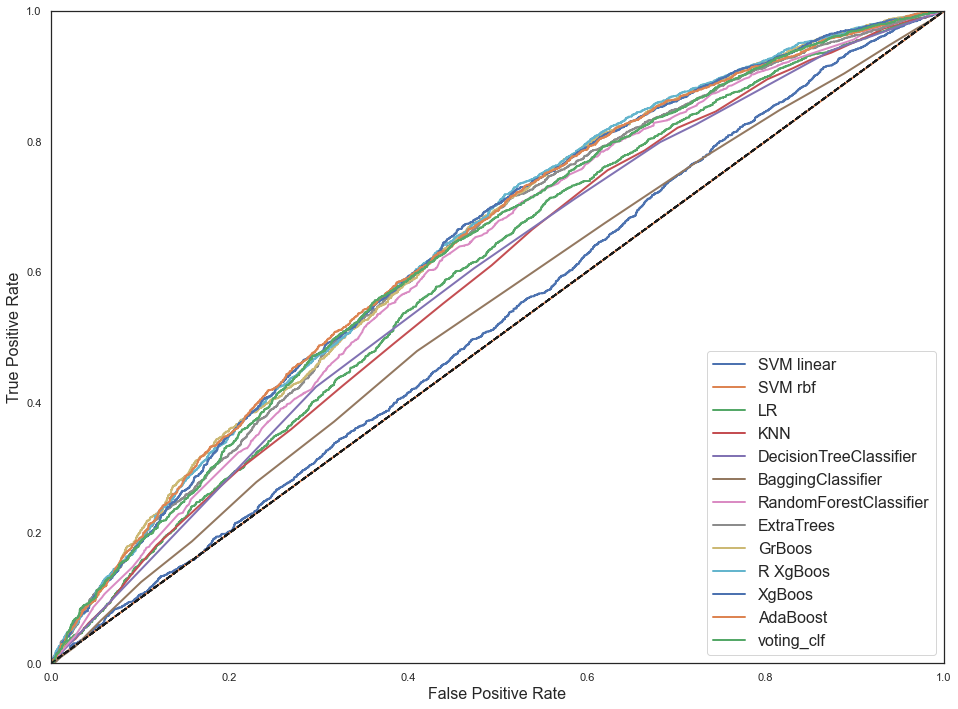

In [137]:
from sklearn.metrics import roc_curve

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(16, 12))
for name, model in models:
    print(name)
    if (name == 'SVM linear'):
        y_scores = model.decision_function(X_test)
    else: 
        y_scores = model.predict_proba(X_test)[:,1]        
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    plot_roc_curve(fpr, tpr, name)

plt.legend(loc="lower right", fontsize=16)
plt.show()

In [120]:
valuse_list = []
for name,model in models:
    valuse_list.append(name)

d = {'precision_score': precision_score, 
     'recall_score': recall_score, 
     'f1_score': f1_score,
     'accuracy_score' : accuracy_score,
     'roc_auc_score' : roc_auc_score
    }
df = pd.DataFrame(data=d)
df.insert(loc=0, column='Method', value=valuse_list)

df

,Method,precision_score,recall_score,f1_score,accuracy_score,roc_auc_score
0,SVM linear,0.571429,0.862131,0.687305,0.561279,0.522232
1,SVM rbf,0.559225,0.999097,0.717079,0.559091,0.499809
2,LR,0.620242,0.647502,0.633579,0.581145,0.595585
3,KNN,0.603925,0.768814,0.676467,0.588721,0.586103
4,DecisionTreeClassifier,0.586650,0.825406,0.685843,0.577104,0.573035
5,BaggingClassifier,0.597239,0.729380,0.656729,0.573569,0.568776
6,RandomForestClassifier,0.603837,0.814871,0.693658,0.597475,0.604865
7,ExtraTrees,0.568205,0.993076,0.722831,0.574074,0.628829
8,GrBoos,0.626089,0.800421,0.702603,0.621044,0.641935
9,R XgBoos,0.631288,0.789585,0.701618,0.624411,0.648321
